# ARIMA and SARIMA (Seasonal ARIMA)

### Autoregressive Integrated Moving Averages

autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity in the sense of mean (but not variance), where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity of the mean function (i.e., the trend). When the seasonality shows in a time series, the seasonal-differencing could be applied to eliminate the seasonal component. Since the ARMA model, according to the Wold's decomposition theorem, is theoritically sufficeint to describe a wide-sense stationary time series, we are motivated to make stationary a non-stationary time series, e.g., by using differencing, before we can use the ARMA model.

# Libraries

In [4]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


import sys
sys.path.append('../')


import inspect
import warnings
warnings.filterwarnings("ignore")


from Functions.arima import *
from Functions.exploratory_data_analysis import *

# Load Data

In [5]:
dataTrain = pd.read_csv('../01-Data/train.csv', parse_dates=['date'], index_col='date')

In [6]:
dataTrain.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


# Massing Values

In [7]:
dataTrain.isnull().any()

store    False
item     False
sales    False
dtype: bool

# Statistic Summary

In [8]:
dataTrain.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


In [9]:
stores = pd.DataFrame(dataTrain.groupby(['date','store']).sum()['sales']).unstack()
stores = stores.resample('M',label='left').sum()
stores.sort_index(inplace = True)

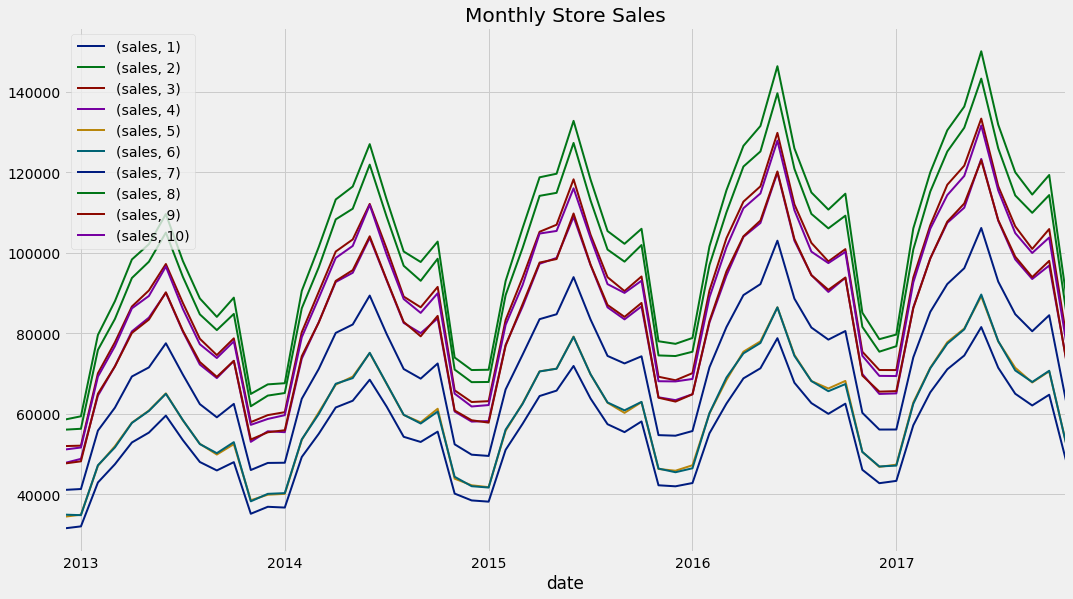

In [20]:
edaPlot(dataTrain, 'Monthly')

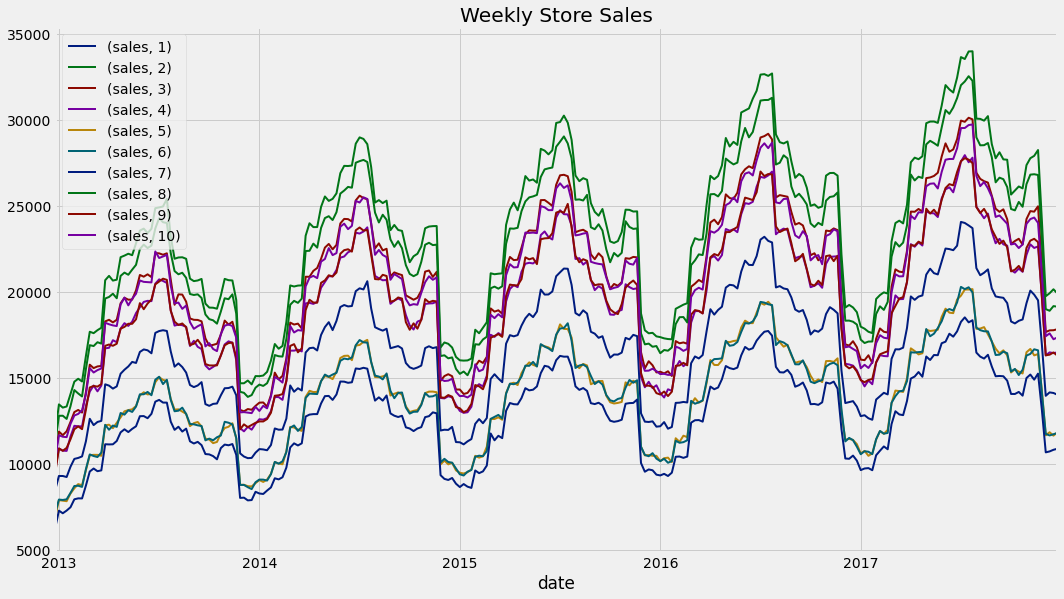

In [21]:
edaPlot(dataTrain, 'Weekly')

As observed in the graphs we perceive a pattern in the sales of the stores and a seasonality

- As we have a pattern among store sales, we will choose one randomly to verify the hypothesis of being stationary through the "adfullerTest" function, which was developed in the arima module

In [15]:
print(inspect.getdoc(adfullerTest))

Return the evidence against the null hypothesis(Ho) for analysis of the stacinonary of the series using the Dickey-Fuller test


Paramaters
----------
timeseries: Pandas Series in which the hypothesis test is to be performed
cutoff: Critical Value (Default -> 0.01)

Returns
-------
Text (Print) to be interpreted


In [16]:
store = np.random.randint(1, len(dataTrain.reset_index()['store'].unique()) + 1, 1)[0]
item = np.random.randint(1, len(dataTrain.reset_index()['item'].unique()) + 1, 1)[0]
print(f' store {store} -> item {item}')
adfullerTest(dataTrain[(dataTrain['store']==store) & (dataTrain['item']==item)]['sales'])

 store 9 -> item 8
ADF Test Statistic : -3.097353062236132
p-value : 0.026749694870145037
#Lags Used : 25
Number of Observations Used : 1800
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


> according to the hypothesis test the Series is **non-stationary**

# Plot the original data and the respective rolling statistics

In [17]:
print(inspect.getdoc(rollingStatsPlot))

Plot y versus x as lines of the original data and the respective rolling statistics

y: Timeseries Values
X: Time

Paramaters
----------
timeseries: Pandas Series to be plotted 
window: Window for rolling statistics (Default -> 12)

Returns
-------
Plot


 store 5 -> item 4 



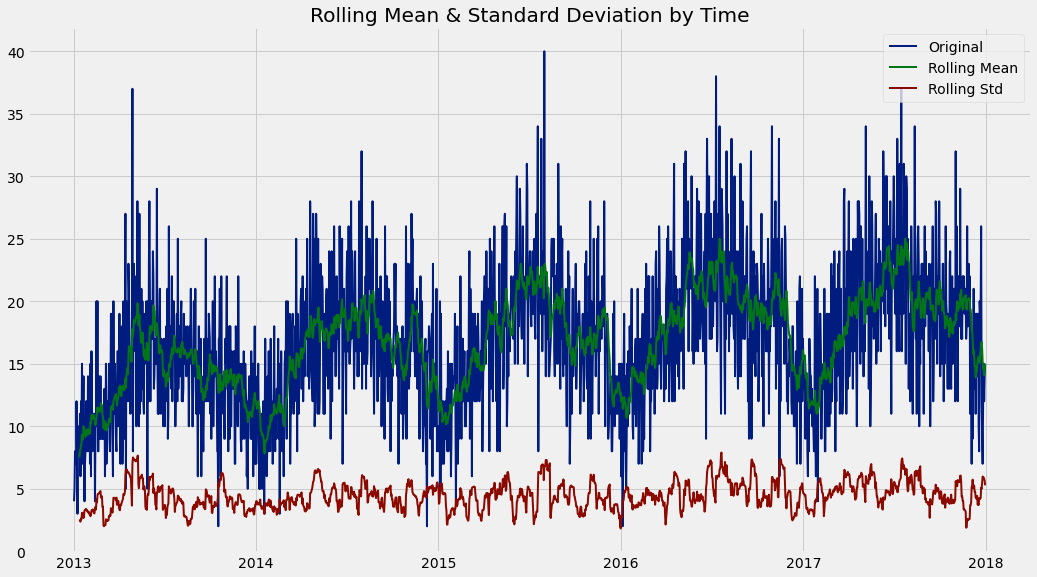

In [18]:
store = np.random.randint(1, len(dataTrain.reset_index()['store'].unique()) + 1, 1)[0]
item = np.random.randint(1, len(dataTrain.reset_index()['item'].unique()) + 1, 1)[0]

item_random = dataTrain[(dataTrain['store']==store) & (dataTrain['item']==item)]
print(f' store {store} -> item {item} \n')
rollingStatsPlot(item_random['sales'])